# Latent Cold Diffusion With a Transformer!

In this Notebook we'll look at implementing a simplified version of a Diffusion Transformer
[DiT](https://arxiv.org/pdf/2212.09748)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from apex.optimizers import FusedAdam
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
import copy
import math
from tqdm.notebook import trange, tqdm
from PIL import Image

from diffusers.models import AutoencoderKL

In [2]:
# Configurations
batch_size = 200
lr = 2e-5
train_epoch = 1200
latent_size = 32
data_set_root = "./datasets"
use_cuda = torch.cuda.is_available()
gpu_indx  = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class LatentDataset(Dataset):
    def __init__(self, latent_dir):
        self.latent_dir = latent_dir
        self.latent_files = sorted(os.listdir(latent_dir))

    def __len__(self):
        return len(self.latent_files)

    def __getitem__(self, idx):
        latent_file = self.latent_files[idx]
        latent = np.load(os.path.join(self.latent_dir, latent_file))
        return torch.tensor(latent)

In [4]:
data_set_root = "./dataset/latent"
trainset = LatentDataset(data_set_root)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=25, pin_memory=True)

In [5]:
def extract_patches(image_tensor, patch_size=8):
    bs, c, h, w = image_tensor.size()
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    unfolded = unfold(image_tensor)
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    return unfolded


def reconstruct_image(patch_sequence, image_shape, patch_size=8):
    """
    Rebuild original images from flattened patches.

    Args:
        patch_sequence (torch.Tensor): Tensor of shape (B, L, C * P * P)
        image_shape (tuple): Original shape (B, C, H, W)
        patch_size (int): Side length of each patch

    Returns:
        torch.Tensor: Reconstructed images of shape (B, C, H, W)
    """
    bs, c, h, w = image_shape
    num_patches_h = h // patch_size
    num_patches_w = w // patch_size
    
    unfolded_shape = (bs, num_patches_h, num_patches_w, patch_size, patch_size, c)
    patch_sequence = patch_sequence.view(*unfolded_shape)
    
    patch_sequence = patch_sequence.permute(0, 5, 1, 3, 2, 4).contiguous()
    
    reconstructed = patch_sequence.view(bs, c, h, w)
    
    return reconstructed

In [6]:
class ConditionalNorm2d(nn.Module):
    def __init__(self, hidden_size, num_features):
        super(ConditionalNorm2d, self).__init__()
        self.norm = nn.LayerNorm(hidden_size, elementwise_affine=False)

        self.fcw = nn.Linear(num_features, hidden_size)
        self.fcb = nn.Linear(num_features, hidden_size)

    def forward(self, x, features):
        bs, s, l = x.shape
        
        out = self.norm(x)
        w = self.fcw(features).reshape(bs, 1, -1)
        b = self.fcb(features).reshape(bs, 1, -1)

        return w * out + b

    
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
    
# Transformer block with self-attention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, num_features=128):
        # Initialize the parent nn.Module
        super(TransformerBlock, self).__init__()
        
        # Layer normalization to normalize the input data
        self.norm = nn.LayerNorm(hidden_size)
        
        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, 
                                                    batch_first=True, dropout=0.0)
        
        # Another layer normalization
        self.con_norm = ConditionalNorm2d(hidden_size, num_features)
        
        # Multi-layer perceptron (MLP) with a hidden layer and activation function
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.LayerNorm(hidden_size * 4),
            nn.ELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
                
    def forward(self, x, features):
        # Apply the first layer normalization
        norm_x = self.norm(x)
        
        # Apply multi-head attention and add the input (residual connection)
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x
        
        # Apply the second layer normalization
        norm_x = self.con_norm(x, features)
        
        # Pass through the MLP and add the input (residual connection)
        x = self.mlp(norm_x) + x
        
        return x

    
# Define a Vision Encoder module for the Diffusion Transformer
class DiT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, 
                 hidden_size=128, num_features=128, 
                 num_layers=3, num_heads=4):
        super(DiT, self).__init__()
        
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(num_features),
            nn.Linear(num_features, 2 * num_features),
            nn.GELU(),
            nn.Linear(2 * num_features, num_features),
            nn.GELU()
        )
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.02))
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, channels_in * patch_size * patch_size)
                
    def forward(self, image_in, index):  
        # Get timestep embedding
        index_features = self.time_mlp(index)

        # Split input into patches
        patch_seq = extract_patches(image_in, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding
        
        # Pass the embeddings through each Transformer block
        for block in self.blocks:
            embs = block(embs, index_features)
        
        # Project to output
        image_out = self.fc_out(embs)
        
        # Reconstruct the input from patches and return result
        return reconstruct_image(image_out, image_in.shape, patch_size=self.patch_size)


## Cosine schedual

In [7]:
def cosine_alphas_bar(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, steps, steps)
    alphas_bar = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]
    return alphas_bar[:timesteps]

## Reverse Cold Diffusion Process 
We're implementing DDIM, specifically cold diffusion, which can use any transformation, however we are just doing de-noising.

[Cold Diffusion](https://arxiv.org/pdf/2208.09392.pdf)

In [8]:
def noise_from_x0(curr_img, img_pred, alpha):
    return (curr_img - alpha.sqrt() * img_pred)/((1 - alpha).sqrt() + 1e-4)

In [9]:
def cold_diffuse(diffusion_model, sample_in, total_steps, start_step=0):
    diffusion_model.eval()
    bs = sample_in.shape[0]
    alphas = torch.flip(cosine_alphas_bar(total_steps), (0,)).to(device)
    random_sample = copy.deepcopy(sample_in)
    with torch.no_grad():
        for i in trange(start_step, total_steps - 1):
            index = (i * torch.ones(bs, device=sample_in.device)).long()

            img_output = diffusion_model(random_sample, index)

            noise = noise_from_x0(random_sample, img_output, alphas[i])
            x0 = img_output

            rep1 = alphas[i].sqrt() * x0 + (1 - alphas[i]).sqrt() * noise
            rep2 = alphas[i + 1].sqrt() * x0 + (1 - alphas[i + 1]).sqrt() * noise

            random_sample += rep2 - rep1

        index = ((total_steps - 1) * torch.ones(bs, device=sample_in.device)).long()
        img_output = diffusion_model(random_sample, index)

    return img_output


In [10]:
# Create a dataloader itterable object
dataiter = iter(train_loader)
# Sample from the itterable object
latents = next(dataiter)

In [11]:
timesteps = 500
patch_size = 2

# network
dit = DiT(latent_size, channels_in=latents.shape[1], patch_size=patch_size, 
            hidden_size=768, num_layers=10, num_heads=8).to(device)

dit = torch.compile(dit, backend="inductor")
# Adam optimizer
optimizer = FusedAdam(dit.parameters(), lr=lr)

# Scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()

alphas = torch.flip(cosine_alphas_bar(timesteps), (0,)).to(device)

/tmp/ipykernel_73895/4171656399.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [12]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in dit.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 73194128 (Approximately 73 Million) Parameters!


In [13]:
# Load Model
model_path = "./models/best_model_1.pt"
if os.path.isfile(model_path):
    cp = torch.load(model_path)
    dit.load_state_dict(cp, strict=True)
else:
    print("No checkpoint found, starting from scratch.")

/tmp/ipykernel_73895/4212705326.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp = torch.load(model_path)


## Training the Model

## Plot the training loss

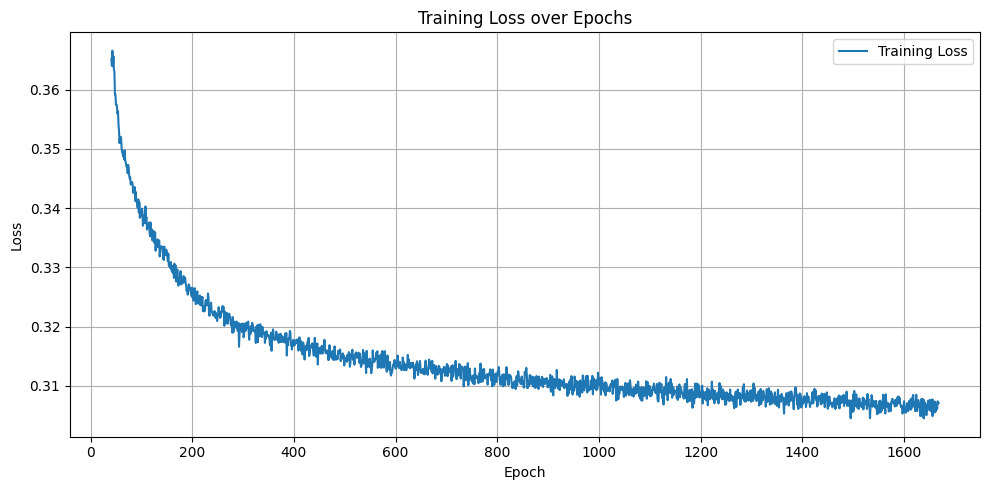

In [14]:
# Load CSV
log_df = pd.read_csv("training_log.csv")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(log_df['epoch'], log_df['avg_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Generate the Images

In [15]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").to(device)

In [16]:
latent_noise = 0.95 * torch.randn(8, 4, latent_size, latent_size, device=device)
with torch.no_grad():
    with torch.cuda.amp.autocast():
        fake_latents = cold_diffuse(dit, latent_noise, total_steps=timesteps)
        fake_sample = vae.decode(fake_latents / 0.18215).sample

/tmp/ipykernel_73895/2090716473.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/499 [00:00<?, ?it/s]

W0423 21:38:39.085000 136088931958784 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] xindex is not in var_ranges, defaulting to unknown range.


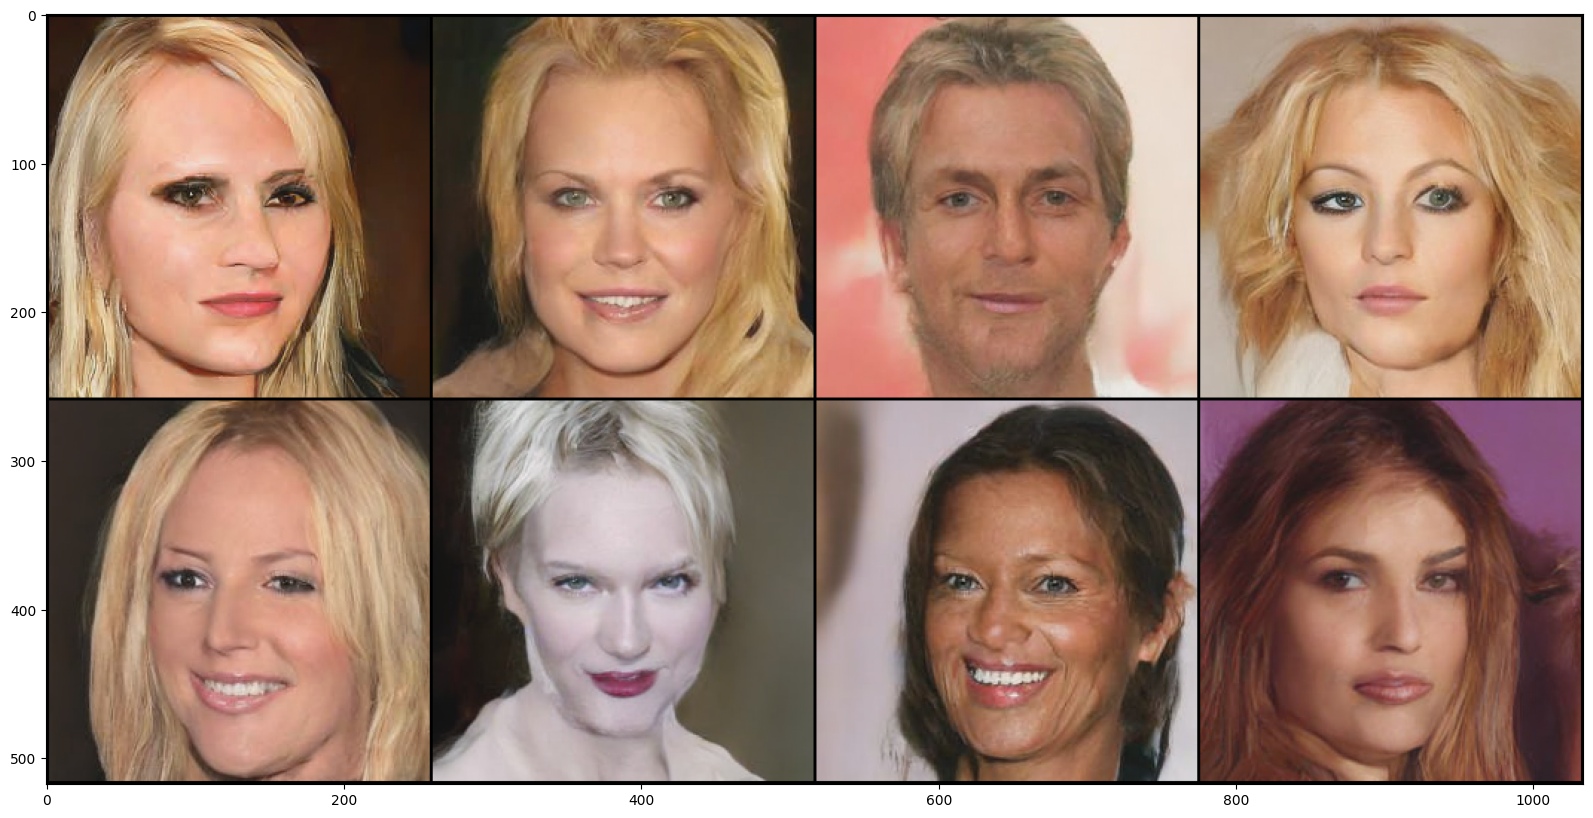

In [17]:
plt.figure(figsize = (20, 10))
out = vutils.make_grid(fake_sample.detach().float().cpu(), nrow=4, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Evaluate the Model

In [18]:
# import torch
# from torch.utils.data import DataLoader
# from torchvision.datasets import ImageFolder
# from torchvision import transforms
# from torchmetrics.image.fid import FrechetInceptionDistance

# # -- Configuration --
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch_size = 64
# timesteps = 500
# latent_scale = 0.18215
# dataset_dir = "./dataset/images"
# max_batches = 50  # <-- Only evaluate on 50 batches

# # -- Transforms for real images (must match training preprocess) --
# eval_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(256),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

# # -- Prepare real dataset loader --
# real_dataset = ImageFolder(dataset_dir, transform=eval_transform)
# real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

# # -- Instantiate FID metric --
# fid = FrechetInceptionDistance(feature=64, normalize=True).to(device)

# # -- 1) Accumulate real image stats --
# fid.eval()
# with torch.no_grad():
#     for i, (imgs, _) in enumerate(real_loader):
#         if i >= max_batches:
#             break
#         fid.update(imgs.to(device), real=True)

# # -- 2) Generate fake images and accumulate fake stats --
# dit.eval()
# vae.eval()
# with torch.no_grad():
#     for _ in range(max_batches):
#         noise = torch.randn(batch_size, 4, latent_size, latent_size, device=device)
#         latents = cold_diffuse(dit, noise, total_steps=timesteps)
#         fake = vae.decode(latents / latent_scale).sample
#         fake = (fake + 1) / 2
#         fake = transforms.functional.normalize(fake, mean=[0.5]*3, std=[0.5]*3)
#         fid.update(fake, real=False)

# # -- 3) Compute and print FID --
# fid_value = fid.compute()
# print(f"Fréchet Inception Distance (FID) on 50 batches: {fid_value:.4f}")

## Image to Image Diffusion

In [19]:
# 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])


In [20]:
# Load a test image!
test_img = Image.open("./data/00507.jpg")
test_tensor = transform(test_img).unsqueeze(0).to(device)

In [21]:
# How many different images to create
mini_batch_size = 8
# How many steps to run the diffusion process
index = 300

with torch.no_grad():
    with torch.cuda.amp.autocast():
        # Encode the image to latent space
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        latent_noise = 0.95 * torch.randn_like(latents)

        # Get the alpha value for the current step
        alpha_batch = alphas[index].expand(mini_batch_size).reshape(mini_batch_size, 
                                                                    1, 1, 1)
        noise_input = alpha_batch.sqrt() * latents +\
        (1 - alpha_batch).sqrt() * latent_noise
        
        # Run the diffusion process
        fake_latents = cold_diffuse(dit, noise_input, 
                                    total_steps=timesteps, 
                                    start_step=index)
        # Decode the generated latents
        fake_sample = vae.decode(fake_latents / 0.18215).sample

/tmp/ipykernel_73895/1321161240.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/199 [00:00<?, ?it/s]

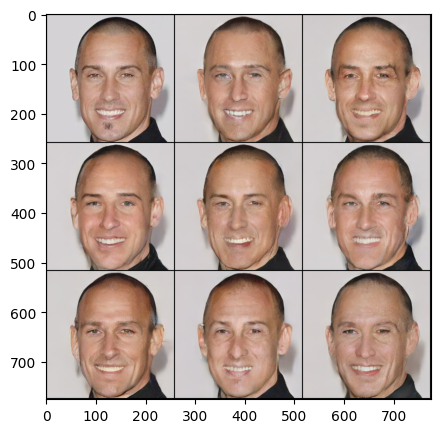

In [22]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Here's a clearer and more structured version of the **Image In-Painting** explanation suitable for a Python notebook:

---

## 🖼️ Image In-Painting with Diffusion

**In-painting** is a technique used to **generate or restore missing regions of an image** using a trained model. In the context of diffusion models, we can guide generation by starting from a noisy image and **forcing certain regions to match a known target** using a mask.

---

### 💡 Concept Overview

1. **Input**: A source image or latent representation.
2. **Mask**: A binary (or soft) tensor where:
   - `1` means “preserve/generate”
   - `0` means “inject target information”
3. **Target**: The image/latent we want to guide generation with.
4. **Forward Process**: Noise the target to match the current step of the diffusion process.
5. **Blending**: At each step, blend the target and the current sample using the mask.
6. **Reverse Process**: Perform the diffusion denoising loop, but constantly reintroduce the masked region with guidance from the target.

---

### 🧩 Step-by-Step Workflow

1. **Define a Mask**  
   Create a binary tensor of shape `(1, H, W)` or `(B, 1, H, W)`:
   ```python
   mask = torch.zeros(1, H, W)
   mask[:, H//4:3*H//4, W//4:3*W//4] = 1.0  # e.g., preserve center
   ```

2. **Encode the Target Image (or use target latent)**  
   Convert the target image into its latent space using a VAE:
   ```python
   with torch.no_grad():
       latents = vae.encode(image).latent_dist.sample() * scale_factor
   ```

3. **Prepare Initial Latents**  
   Start the diffusion with pure noise:
   ```python
   noise = torch.randn_like(latents)
   ```

4. **Modify Diffusion Loop to Apply Mask at Each Step**  
   At each timestep `t`:
   - Add noise to the target image to match the current diffusion step.
   - Replace the masked region in the current sample with the noisy target:
     ```python
     current = mask * current + (1 - mask) * noisy_target
     ```

5. **Perform Reverse Diffusion**  
   Continue the reverse process until final latents are generated.

6. **Decode Final Latents**  
   Convert latents back into images:
   ```python
   final = vae.decode(latents / scale_factor).sample
   ```

---

### ✅ Benefits of In-Painting with Diffusion

- **Flexible**: Works with arbitrary mask shapes.
- **High Quality**: Diffusion retains consistency and fine detail.
- **Conditional Control**: You can softly or strongly control the generated regions.

---

In [23]:
def cold_diffuse_inpaint(diffusion_model, sample_in, target, mask, 
                         total_steps, start_step=0):
    diffusion_model.eval()
    bs = sample_in.shape[0]
    alphas = torch.flip(cosine_alphas_bar(total_steps), (0,)).to(device)
    random_sample = copy.deepcopy(sample_in)
    
    with torch.no_grad():
        for i in trange(start_step, total_steps - 1):
            index = (i * torch.ones(bs, device=sample_in.device)).long()

            # noising up the target to match the same step in the process
            noisy_target = alphas[i].sqrt() * target +\
            (1 - alphas[i]).sqrt() * torch.randn_like(target)
                
            # Use the mask to replace certain parts of the generation with the 
            # noisy target
            random_sample = mask * random_sample + (1 - mask) * noisy_target
            
            img_output = diffusion_model(random_sample, index)

            noise = noise_from_x0(random_sample, img_output, alphas[i])
            x0 = img_output

            rep1 = alphas[i].sqrt() * x0 + (1 - alphas[i]).sqrt() * noise
            rep2 = alphas[i + 1].sqrt() * x0 + (1 - alphas[i + 1]).sqrt() * noise
            
            # The current latent in the diffusion generation process
            random_sample += rep2 - rep1
            
        index = ((total_steps - 1) * torch.ones(bs, device=sample_in.device)).long()
        img_output = diffusion_model(random_sample, index)

    return img_output


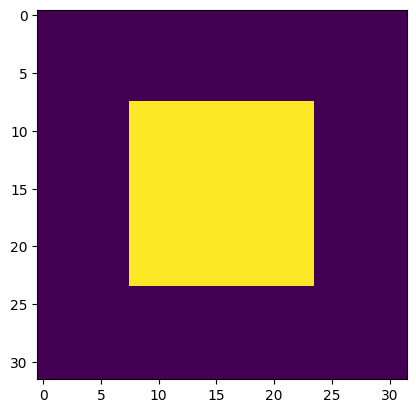

In [24]:
#  1 means “preserve/generate”
#  0 means “inject target information”
mask = torch.zeros(1, latent_size, latent_size, device=device)
mask[:, 8:latent_size-8, 8:latent_size-8] = torch.ones(16, 16, device=device)
_ = plt.imshow(mask[0].cpu().numpy())

In [25]:
mini_batch_size = 8

with torch.no_grad():
    with torch.cuda.amp.autocast():
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        noise_input = 0.9 * torch.randn_like(latents)

        fake_latents = cold_diffuse_inpaint(dit, 
                                            noise_input, 
                                            total_steps=timesteps,
                                            target=latents,
                                            mask=mask)
        
        fake_sample = vae.decode(fake_latents / 0.18215).sample

/tmp/ipykernel_73895/2341720753.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/499 [00:00<?, ?it/s]

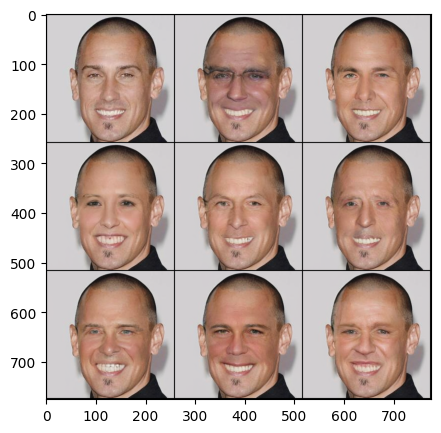

In [26]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

### Invert the mask

In [27]:
mini_batch_size = 8

with torch.no_grad():
    with torch.cuda.amp.autocast():
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        noise_input = 0.9 * torch.randn_like(latents)

        fake_latents = cold_diffuse_inpaint(dit, 
                                            noise_input, 
                                            total_steps=timesteps,
                                            target=latents,
                                            mask=1 - mask)  # Invert the mask
        
        fake_sample = vae.decode(fake_latents / 0.18215).sample

/tmp/ipykernel_73895/626610571.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/499 [00:00<?, ?it/s]

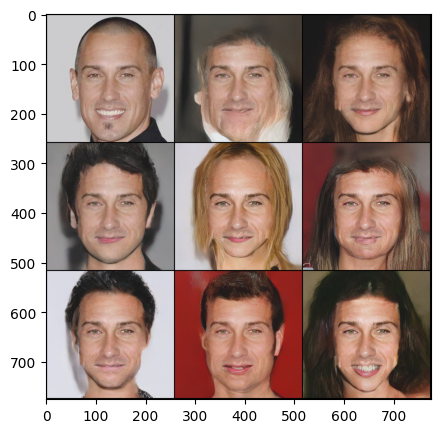

In [28]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

## Smooth Mask
A smooth mask contains continuous values between 0 and 1, allowing the model to blend between the source (target image) and generated content. This results in more natural transitions, especially around the boundaries of the masked area.

In [29]:
# Setup data:
mask_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

In [30]:
face_mask = Image.open("./data/ob_face_mask.png")
face_mask_tensor = mask_transform(face_mask).unsqueeze(0).to(device)

bg_mask = Image.open("./data/ob_bg_mask.png")
bg_mask_tensor = mask_transform(bg_mask).unsqueeze(0).to(device)

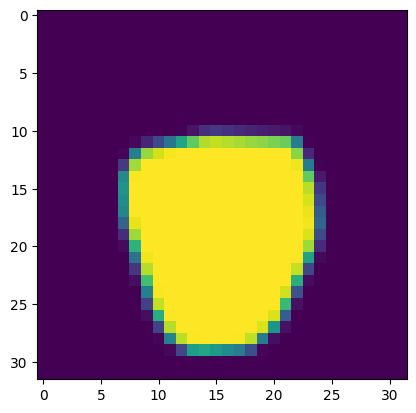

In [31]:
_ = plt.imshow(face_mask_tensor[0, 0].cpu().numpy())

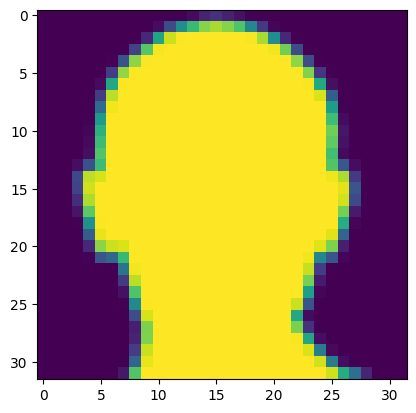

In [32]:
# Mask of the whole body
_ = plt.imshow(bg_mask_tensor[0, 0].cpu().numpy())

In [33]:
mini_batch_size = 8

with torch.no_grad():
    with torch.cuda.amp.autocast():
        latents = vae.encode(test_tensor).latent_dist.sample().mul_(0.18215)
        latents = latents.expand(mini_batch_size, 4, latent_size, latent_size)
        noise_input = 0.9 * torch.randn_like(latents)

        fake_latents = cold_diffuse_inpaint(dit, 
                                            noise_input, 
                                            total_steps=timesteps,
                                            target=latents,
                                            mask=1 - face_mask_tensor)
        
        fake_sample = vae.decode(fake_latents / 0.18215).sample

/tmp/ipykernel_73895/3156984127.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/499 [00:00<?, ?it/s]

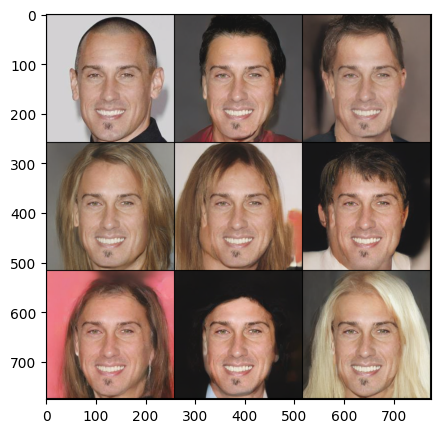

In [34]:
plt.figure(figsize = (5, 5))
comb_samples = torch.cat((test_tensor, fake_sample.detach()), 0)
out = vutils.make_grid(comb_samples.detach().float().cpu(), nrow=3, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))